In [228]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import pdb

%matplotlib inline

In [2]:
device = "cpu" if torch.cuda.is_available() else "cuda:0" # если у тебя только CPU, то автоматически device = 'cpu'

In [3]:
device='cpu'

## Define target density

In [4]:
class Correlated_gaussian():
    '''
    This class defines correlated gaussian target (2d)
    '''
    def __init__(self, mu, covar):
        self.distr = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=covar)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, )) # аргументом должен быть iterable

In [5]:
## Option 1
mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
covar = torch.tensor([[1., 0.95], [0.95, 1.]], device=device, dtype=torch.float32)

# ## Option 2
# mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
# covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

In [6]:
target = Correlated_gaussian(mu, covar)

## Plot samples from the target

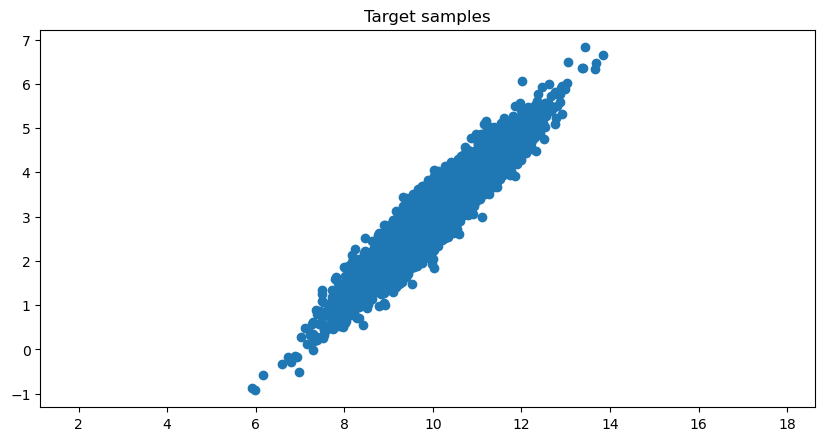

In [7]:
samples = target.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

## Variational inference

Мы выберем простое вариационное распределение: mean-field gaussian

Оно параметризуется двумя векторами -- вектор средних и вектор стандартных отклонений.

In [8]:
# torch.nn.Parameter -- это объект, который далее передается в оптимизатор, по параметрами после производится оптимизация
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

# обрати внимание, что это std_raw. Std должен быть >0, поэтому мы будем оптимизировать "сырой" вектор,
# который каждый раз будем подставлять в экспоненту

# то есть стартовые параметры, mu_param = 0, 0; std = exp(std_param_raw) = 1, 1
std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw],
                            lr=1e-2) # добавляем параметры в оптимайзер
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)


# стандартное нормальное распределение нужно нам для reparametrization trick (будет в статье про VAE)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [9]:
batch_size = 1000
num_batches = 10000

KL$(q_{\phi}(z)\|p(z)) = \int_z q_{\phi}(z)\log\frac{q_{\phi}(z)}{p(z)} dz = E_{q_{\phi}(z)}\log q_{\phi}(z) - E _{q_{\phi}(z)}\log p(z)$

Оценки мат.ожиданий из формулы выше будем брать методом Монте-Карло, то есть с помощью семплов

In [10]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2)) # это пригодится для reparametrization trick
    
    # Берем семплы из вариационного распределения:
    std = torch.exp(std_param_raw)
    z = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
                                                # случайные ноды в графе не распространяется
    ## посчитали KL по формуле выше
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target.get_logdensity(z).mean()
    
    # А дальше просто минимизируем KL:
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  1%|▉                                                                            | 128/10000 [00:00<00:14, 690.84it/s]

Current value of KL at batch number 0 is 277.86865234375


 11%|████████▎                                                                   | 1092/10000 [00:01<00:09, 948.93it/s]

Current value of KL at batch number 1000 is 18.379152297973633


 21%|████████████████                                                            | 2110/10000 [00:02<00:08, 918.87it/s]

Current value of KL at batch number 2000 is 9.87135124206543


 32%|████████████████████████                                                    | 3164/10000 [00:03<00:07, 963.47it/s]

Current value of KL at batch number 3000 is 3.7429726123809814


 41%|███████████████████████████████                                            | 4136/10000 [00:04<00:05, 1003.78it/s]

Current value of KL at batch number 4000 is 1.5428533554077148


 52%|███████████████████████████████████████▍                                    | 5183/10000 [00:05<00:05, 936.97it/s]

Current value of KL at batch number 5000 is 1.1306140422821045


 61%|█████████████████████████████████████████████▋                             | 6087/10000 [00:06<00:03, 1078.11it/s]

Current value of KL at batch number 6000 is 1.1654497385025024


 71%|█████████████████████████████████████████████████████▉                      | 7095/10000 [00:07<00:03, 958.32it/s]

Current value of KL at batch number 7000 is 1.1419786214828491


 82%|█████████████████████████████████████████████████████████████▉              | 8152/10000 [00:08<00:02, 904.76it/s]

Current value of KL at batch number 8000 is 1.1847310066223145


 91%|█████████████████████████████████████████████████████████████████████▏      | 9098/10000 [00:09<00:01, 898.67it/s]

Current value of KL at batch number 9000 is 1.1947758197784424


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 945.34it/s]


### Plot both: samples from variational family and target

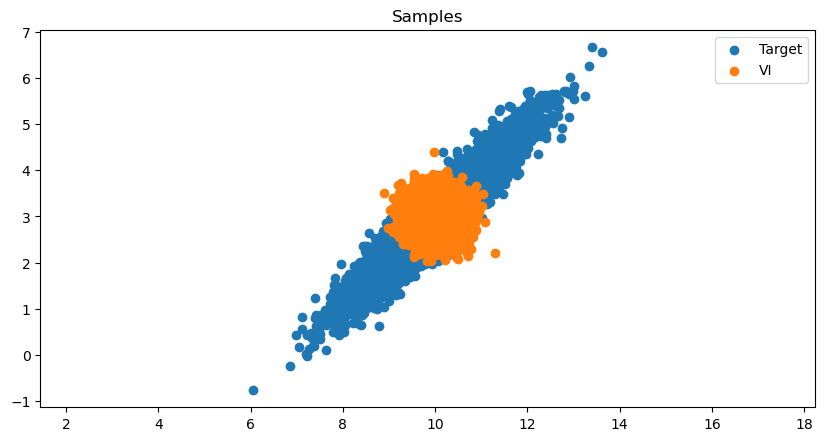

In [11]:
N = 5000

u = std_normal.sample((N, 2)) # это пригодится для reparametrization trick
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
    
samples_target = target.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## VI with GMM target

### Target

In [12]:
#### TODO: Добавь VI, таргетом для которого будет смесь двух гауссиан

class GMM():
    '''
    This class defines GMM (Gaussian Mixture Model) target (2d)
    '''
    def __init__(self, mus, covars):
        self.mus = mus
        self.covars = covars
        self.distr = torch.distributions.MixtureSameFamily(mus, covars)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, ))

In [31]:
mix = torch.distributions.Categorical(torch.ones(2,))
comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)

In [32]:
target_gmm = GMM(mix, comp)

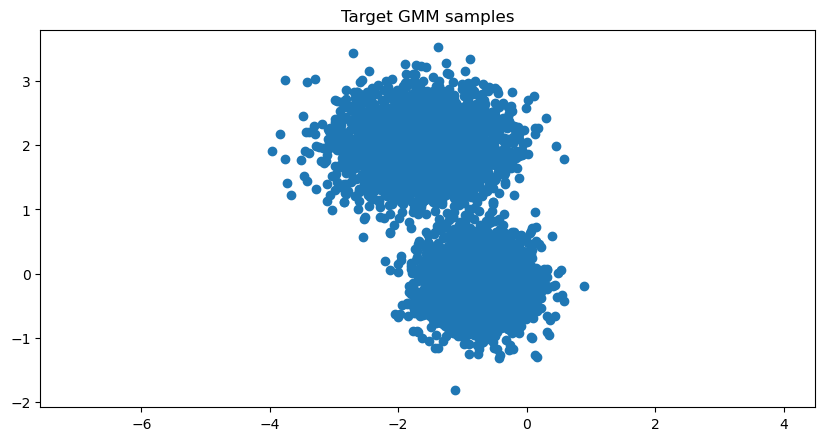

In [33]:
samples = target_gmm.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target GMM samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

### VI model: unimodal Gaussian

In [138]:
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [139]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2))
    
    std = torch.exp(std_param_raw)
    z = mu_param + u * std
    
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target_gmm.get_logdensity(z).mean()
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  1%|▌                                                                             | 79/10000 [00:00<00:12, 779.51it/s]

Current value of KL at batch number 0 is 4.43917179107666


 11%|████████▍                                                                   | 1111/10000 [00:01<00:09, 931.23it/s]

Current value of KL at batch number 1000 is 0.6793107986450195


 21%|████████████████▎                                                           | 2145/10000 [00:02<00:08, 936.09it/s]

Current value of KL at batch number 2000 is 0.6843528747558594


 32%|████████████████████████                                                    | 3164/10000 [00:03<00:07, 875.31it/s]

Current value of KL at batch number 3000 is 0.675400972366333


 42%|███████████████████████████████▌                                            | 4159/10000 [00:04<00:06, 873.26it/s]

Current value of KL at batch number 4000 is 0.6726560592651367


 52%|███████████████████████████████████████▏                                    | 5151/10000 [00:05<00:05, 870.52it/s]

Current value of KL at batch number 5000 is 0.6838055849075317


 62%|██████████████████████████████████████████████▉                             | 6169/10000 [00:06<00:04, 930.16it/s]

Current value of KL at batch number 6000 is 0.6876652240753174


 72%|██████████████████████████████████████████████████████▋                     | 7197/10000 [00:07<00:03, 930.10it/s]

Current value of KL at batch number 7000 is 0.683941125869751


 81%|█████████████████████████████████████████████████████████████▊              | 8135/10000 [00:08<00:02, 925.14it/s]

Current value of KL at batch number 8000 is 0.6738349199295044


 92%|█████████████████████████████████████████████████████████████████████▋      | 9166/10000 [00:10<00:00, 934.93it/s]

Current value of KL at batch number 9000 is 0.6789917945861816


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 911.10it/s]


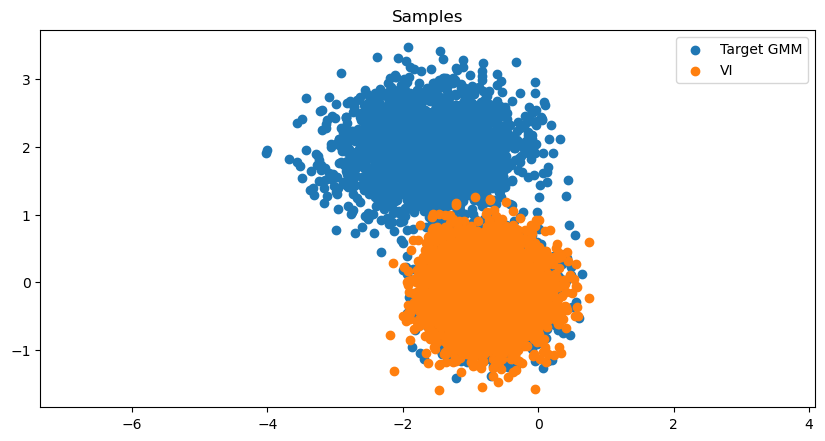

In [121]:
N = 5000

u = std_normal.sample((N, 2))
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## Approximating a mixture of Gaussians

In [279]:
mus_param = nn.Parameter(torch.tensor([[0., 0.],[1., 1.]], device=device, dtype=torch.float32))

stds_param_raw = nn.Parameter(torch.tensor([[0., 0.],[0., 0.]], device=device, dtype=torch.float32))

pi_raw = nn.Parameter(torch.tensor(0., device=device, dtype=torch.float32))

optimizer = torch.optim.Adam(params=[mus_param, stds_param_raw, pi_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal = torch.distributions.Normal(loc=torch.tensor([0., 0.], device=device, dtype=torch.float32),
                                       scale=torch.tensor([1., 1.], device=device, dtype=torch.float32))

KL_values = []
#std_normal1 = torch.distributions.Normal(loc=mus_param[0], scale=torch.tensor(1., device=device, dtype=torch.float32))
#std_normal2 = torch.distributions.Normal(loc=mus_param[1], scale=torch.tensor(1., device=device, dtype=torch.float32))

#mix = torch.distributions.Categorical(pi)
#comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)
#std_normal_mix = torch.distributions.MixtureSameFamily(mix, comp)

In [280]:
for i in tqdm(range(num_batches)):
    pi = torch.sigmoid(pi_raw)
    
    dist = torch.distributions.Bernoulli(probs=torch.sigmoid(pi_raw))
    c = int(dist.sample((1,))[0].item())
    
    std = torch.exp(stds_param_raw)
    
    #std_normal1 = torch.distributions.Normal(loc=mus_param[0], scale=torch.tensor(1., device=device, dtype=torch.float32))
    #std_normal2 = torch.distributions.Normal(loc=mus_param[1], scale=torch.tensor(1., device=device, dtype=torch.float32))
    #u = std_normal1.sample((batch_size, 2)) * c + std_normal2.sample((batch_size, 2)) * (1 - c)
    
    u = std_normal.sample((batch_size, 2))
    
    z = mus_param[c] + u[:, c] * std[c] # сэмпл из одной из гауссиан в зависимости от pi
                                                            # только координаты конкретной гауссианы - u[:, c], координаты обеих - u[:]
    KL = -torch.sum(stds_param_raw) + std_normal.log_prob(u).sum(1).mean() * ( std_normal.log_prob(u).sum(1).mean() + 1 - target_gmm.get_logdensity(z).mean() ).detach() - target_gmm.get_logdensity(z).mean()
    #KL = -torch.sum(stds_param_raw) + std_normal.log_prob(u).sum(1).mean() * ( std_normal.log_prob(u).sum(1).mean() + 1 - target_gmm.get_logdensity(z).mean() ).detach() - target_gmm.get_logdensity(z).mean()
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")
        KL_values.append([i, KL.cpu().detach().numpy().item()])

  1%|▊                                                                             | 97/10000 [00:00<00:20, 485.84it/s]

Current value of KL at batch number 0 is -17.294845581054688


 11%|████████▏                                                                   | 1076/10000 [00:02<00:17, 508.18it/s]

Current value of KL at batch number 1000 is -1.0241625308990479


 21%|███████████████▌                                                            | 2055/10000 [00:04<00:16, 476.76it/s]

Current value of KL at batch number 2000 is -0.9992749691009521


 31%|███████████████████████▎                                                    | 3072/10000 [00:06<00:14, 488.96it/s]

Current value of KL at batch number 3000 is -1.5530180931091309


 41%|███████████████████████████████▏                                            | 4100/10000 [00:08<00:11, 511.12it/s]

Current value of KL at batch number 4000 is -2.1228671073913574


 51%|██████████████████████████████████████▌                                     | 5082/10000 [00:10<00:09, 510.35it/s]

Current value of KL at batch number 5000 is -1.918837070465088


 61%|██████████████████████████████████████████████                              | 6063/10000 [00:12<00:07, 509.44it/s]

Current value of KL at batch number 6000 is -1.319014549255371


 71%|█████████████████████████████████████████████████████▉                      | 7093/10000 [00:14<00:05, 508.16it/s]

Current value of KL at batch number 7000 is -1.6137728691101074


 81%|█████████████████████████████████████████████████████████████▎              | 8074/10000 [00:16<00:03, 509.18it/s]

Current value of KL at batch number 8000 is -2.0743408203125


 91%|████████████████████████████████████████████████████████████████████▊       | 9052/10000 [00:17<00:01, 508.64it/s]

Current value of KL at batch number 9000 is -1.4074113368988037


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 503.09it/s]


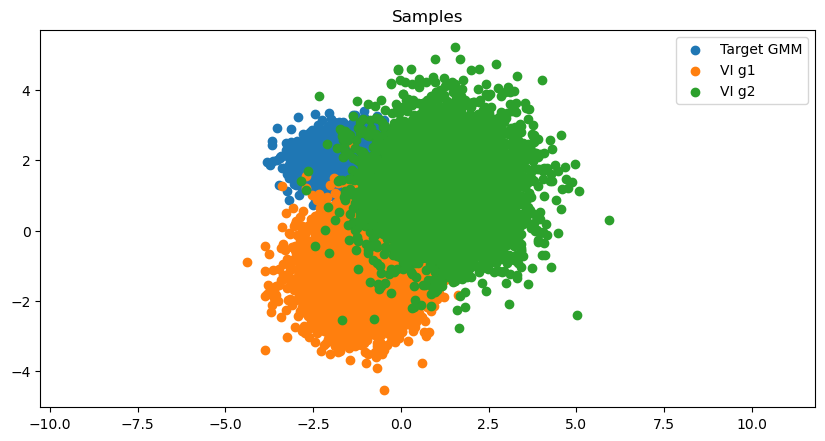

In [281]:
N = 5000

dist = torch.distributions.Bernoulli(probs=torch.sigmoid(pi_raw))
c = dist.sample((5000,1,1))
#c = torch.cat((c,c), dim=1)
c = torch.cat((c,c), dim=2) # to same dim as u
 
u = std_normal.sample((N,2))

with torch.no_grad():
    std = torch.exp(stds_param_raw)
    sample_varfamily = (mus_param[0] + u * std[0]) * (1-c) + (mus_param[1] + u * std[1]) * c
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0, 0], sample_varfamily[:, 1,0], label='VI g1', alpha=1)
plt.scatter(sample_varfamily[:, 0, 1], sample_varfamily[:, 1,1], label='VI g2', alpha=1)
plt.axis('equal')
plt.legend();

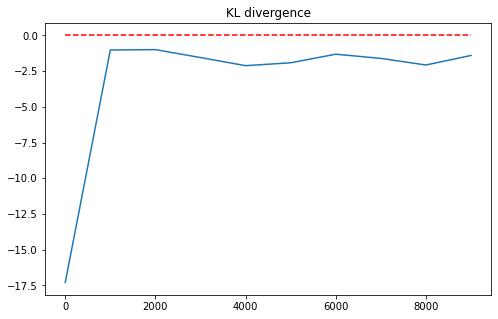

In [282]:
KL_values = np.array(KL_values)
plt.figure(figsize=(8, 5))
plt.title('KL divergence')
plt.plot(KL_values[:,0], KL_values[:,1])
plt.hlines(0, KL_values[:,0][0], KL_values[:,0][-1], color='r', linestyles='--')

In [283]:
pi_raw, mus_param, stds_param_raw

(Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor([[-1.1900,  1.2597],
         [-1.1699,  1.2214]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1664,  0.0805],
         [-0.2403,  0.1202]], requires_grad=True))